# Printing point clouds

In [1]:
import subprocess
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
from IPython.display import Image as display_image

import astro3d

## Setup

Load data

In [2]:
with np.load('data.npz') as fid:
    data = fid['rho']
    x    = fid['x']
    y    = fid['y']
    z    = fid['z']

Set output path

In [3]:
path = Path(astro3d.get_output()) / 'shock_surfaces'
path.mkdir(exist_ok=True)

Set a filling fraction of the dithering

In [4]:
fill = 0.25

define a color palette matching CMYK but with white as black

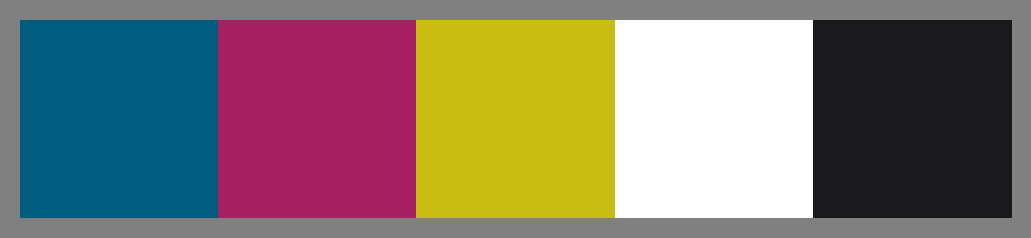

In [5]:
palette = np.array(astro3d.image_stack.vero_palette)[[2,3,4,1,0]]
ax = plt.imshow([palette]).axes
ax.axis('off')
ax.figure.set_facecolor('0.5')

## Explanation

Display a single slice

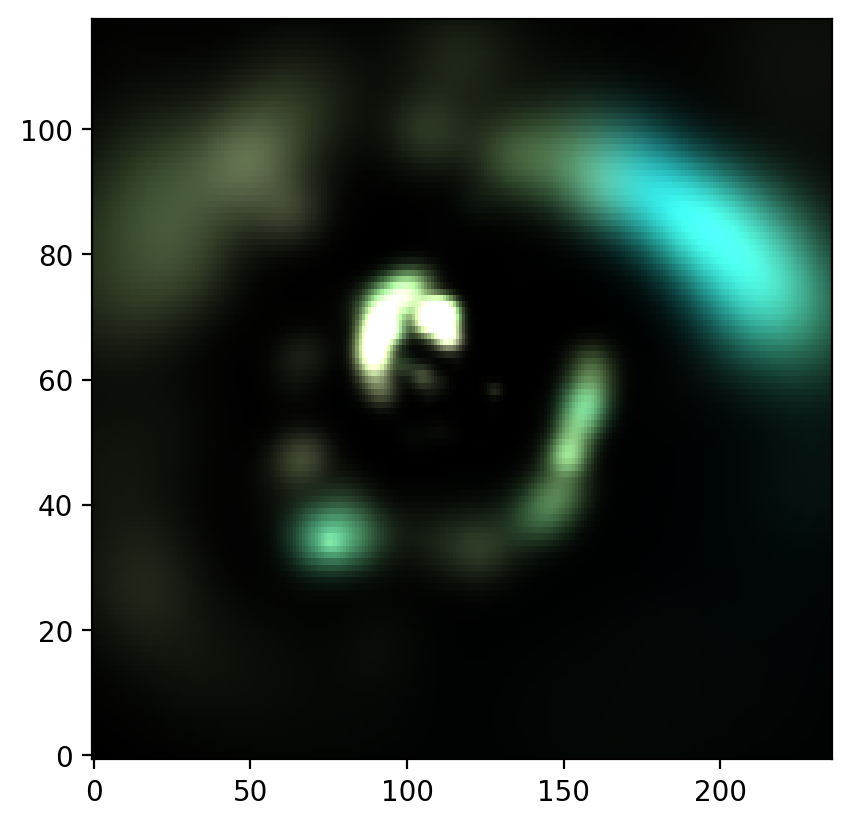

In [98]:
iz = data.shape[2] // 2

f, ax = plt.subplots()
ax.imshow(data[:, :, iz, :].transpose(1, 0, 2), origin='lower')
ax.set_aspect(2)

In [101]:
slice = np.zeros([*data.shape[:2], 4], dtype=np.uint8)
slice[:, :, :3] = data[:, :, iz, :]

In [277]:
from PIL import Image, ImageEnhance
img = Image.fromarray(slice.transpose(1, 0, 2), mode='CMYK').convert('RGB')

In [288]:
np.shape(img)

(118, 236, 3)

In [318]:
imd = astro3d.image_stack.dither_palette(255 - data[:, :, iz, :3], palette)

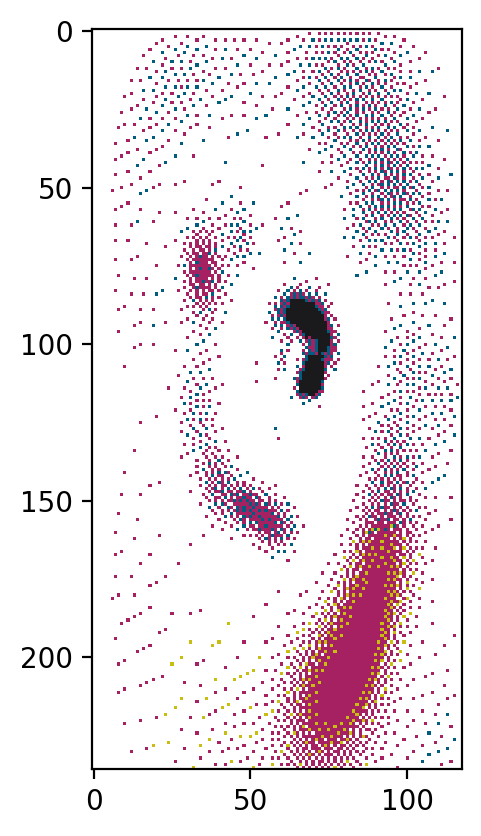

In [124]:
plt.imshow(imd)

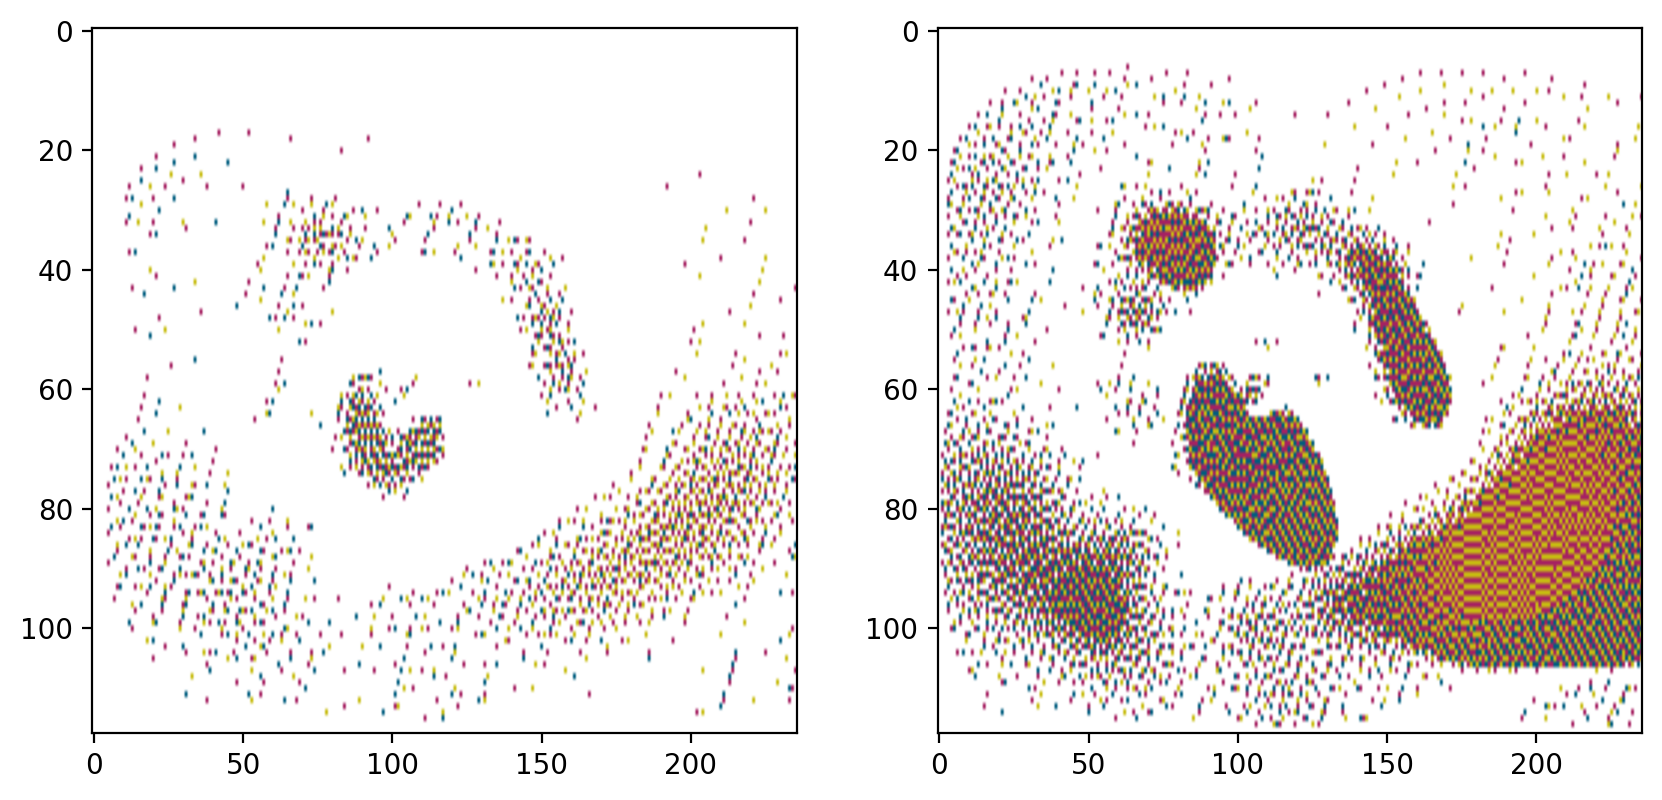

In [105]:
# also show the fill=1 example
layer, im1 = astro3d.image_stack.makeslice_from_colordensity(None, data[:, :, iz, :].transpose(1, 0, 2) / 255.0, iz, fill=fill, colors=palette)
layer, im2 = astro3d.image_stack.makeslice_from_colordensity(None, data[:, :, iz, :].transpose(1, 0, 2) / 255.0, iz, fill=1, colors=palette)

f, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(im1)
axs[1].imshow(im2)
for ax in axs:
    ax.set_aspect(2)

## Production

First we define a function that does this the above procedure for us

In [ ]:
def worker_function(ranges):
    # loop over the given ranges
    iz0, iz1 = ranges
    for iz in range(iz0, iz1):
        
        # get the layer and convert to CMYK
        data_slice = data[:, :, iz, :]
        cmyk_array = np.array(Image.fromarray(data_slice).convert('CMYK'))

        # this makes everything non-black, so we have to invent a black channel
        mask = 1 - data_slice.mean(-1) / 255
        cmyk_array[:, :, -1] = 255 * mask
        cmyk_array[:, :, :3] = (cmyk_array[:, :, :3] * (1 - mask[:, :, None])).astype(np.uint8)

        # dither the colors
        im1, im2 = astro3d.image_stack.makeslice_from_colordensity(
            path,
            cmyk_array[:, :, :3].transpose(1, 0, 2) / 255.0,
            iz, fill=fill, colors=palette)
    return 0

### Serial execution

In [ ]:
%%time
worker_function([0, data.shape[2]])

### Parallel execution

To be able to do this inside a notebook, we use `multiprocess` since `multiprocessing` will not be able to pickle the worker function

In [ ]:
import multiprocess as mp

In [ ]:
# define the number of workers, and the ranges on which each is working
n_workers = mp.cpu_count()
chunk_size = int(data.shape[2] / n_workers)
ranges = [[i * chunk_size, (i + 1) * chunk_size] for i in range(n_workers)]
ranges[-1][-1] = data.shape[2]

Execute

In [ ]:
%%time
with mp.get_context().Pool() as pool:
    pool.map(worker_function, ranges)

# Analyze Stack

In [ ]:
stack = astro3d.image_stack.IStack(path)
stack.show_colors()

In [ ]:
stack.empty_indices = [0]

In [ ]:
f, axs = stack.three_views()